In [1]:
#pip install torch transformers scikit-learn pandas numpy matplotlib

In [2]:
import torch
from torch import linalg
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Create device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda


In [4]:
def gen_svd_bic(A, S, U, Vt):
    rows, cols = tuple(A.shape)
    n = rows * cols
    for k in range(1, S.shape[0]):
        Ak = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
        rss = torch.sum((A - Ak)**2).item()
        sigma = np.sqrt(torch.sum(S[k:]**2).item())
        llh = rss / (2 * sigma**2)
        llh += n * np.log(2 * np.pi * sigma**2) / 2
        #bic = (n * np.log(rss)) + (2 * n * k * np.log(n))
        p = k * (rows + cols + 1)
        bic = (p * np.log(n)) + (2*llh)
        #print(f"BIC for k={k}: {bic}")
        yield bic

In [5]:
def gen_svd_bic2(A, S, U, Vt):
    rows, cols = tuple(A.shape)
    n = rows * cols
    for k in range(1, S.shape[0]):
        Ak = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
        Ares = (A - Ak).flatten().cpu().numpy()
        mu, sigma = scipy.stats.norm.fit(Ares)
        llh = np.sum(scipy.stats.norm.logpdf(Ares, mu, sigma))
        p = k * (rows + cols + 1)
        bic = (p * np.log(n)) - (2*llh)
        yield bic

In [6]:
def gen_svd_bic3(A, S, U, Vt):
    rows, cols = tuple(A.shape)
    n = rows * cols
    for k in range(1, S.shape[0]):
        Ak = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
        Ares = (A - Ak).flatten().cpu().numpy()
        mu = np.median(Ares)
        sigma = 1.4826 * scipy.stats.median_abs_deviation(Ares,center=np.median)
        llh = np.sum(scipy.stats.norm.logpdf(Ares, mu, sigma))
        p = k * (rows + cols + 1)
        bic = (p * np.log(n)) - (2*llh)
        yield bic


In [7]:
def gen_svd_aic(A, S, U, Vt):
    rows, cols = tuple(A.shape)
    n = rows * cols
    for k in range(1, S.shape[0]):
        Ak = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
        Ares = (A - Ak).flatten().cpu().numpy()
        mu, sigma = scipy.stats.norm.fit(Ares)
        llh = np.sum(scipy.stats.norm.logpdf(Ares, mu, sigma))
        p = k * (rows + cols + 1)
        aic = p - llh
        yield aic

In [8]:
def matrix_with_rank(k, rows, cols, scale=100):
    A = torch.randn(rows, cols, device=device, dtype=torch.float32)
    U, S, Vt = torch.linalg.svd(A, full_matrices=False)
    for j in range(k, S.shape[0]):
        S[j] /= scale
    return U @ torch.diag(S) @ Vt

In [9]:
def plot_residuals(ks, A, S, U, Vt):
    nk = len(ks)
    fig, axs = plt.subplots(nk, 1, figsize=(8, nk*3))
    axs = list(axs)
    xmin, xmax = -1e-3, +1e-3
    ymax = 0
    for ax, k in zip(axs, ks):
        Ak = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
        Ares = (A - Ak).flatten().cpu().numpy()
        densities, edges = np.histogram(Ares, bins=50, density=True)
        ymax = max(ymax, np.max(densities))
        xmin = min(xmin, np.min(edges))
        xmax = max(xmax, np.max(edges))
        widths = np.diff(edges)
        ax.bar(edges[:-1], densities, width=widths, edgecolor='black')
        ax.set_xlabel('Residual')
        ax.set_ylabel('Density')
        ax.set_title(f'Residuals for k={k}')
    for ax in axs:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0, 1.1*ymax)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_svd(S, bic):
    S = np.array(S)
    bic = np.array(bic)

    # Plot singular values and cumulative energy
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 9))

    # Singular values
    ax1.semilogy(np.arange(1, 1+S.shape[0]),S)
    ax1.set_title('Singular Values')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Singular Value')
    ax1.grid(True)

    # BIC
    rankBIC = 1+bic.argmin()
    ax2.plot(np.arange(1, 1+bic.shape[0]),bic)
    ax2.set_title('BIC')
    ax2.set_xlabel('Number of Singular Values')
    ax2.set_ylabel('BIC')
    ax2.grid(True)
    ax2.axvline(x=rankBIC, color='k', linestyle='--', label=f'BIC Rank = {rankBIC}')
    ax2.legend()

    # Cumulative energy
    energy = S**2
    cumulative_energy = np.cumsum(energy) / np.sum(energy)
    rank90 = 1+np.argmax(cumulative_energy >= 0.9)

    ax3.plot(np.arange(1, 1+cumulative_energy.shape[0]),cumulative_energy)
    ax3.set_title('Cumulative Energy')
    ax3.set_xlabel('Number of Singular Values')
    ax3.set_ylabel('Fraction of Total Energy')
    ax3.grid(True)
    ax3.axhline(y=0.9, color='r', linestyle='--', label='90% Energy')
    ax3.axvline(x=rank90, color='r', linestyle='--', label=f'90% Rank = {rank90}')
    ax3.axvline(x=rankBIC, color='k', linestyle='--', label=f'BIC Rank = {rankBIC}')
    ax3.legend()


    plt.tight_layout()
    plt.show()


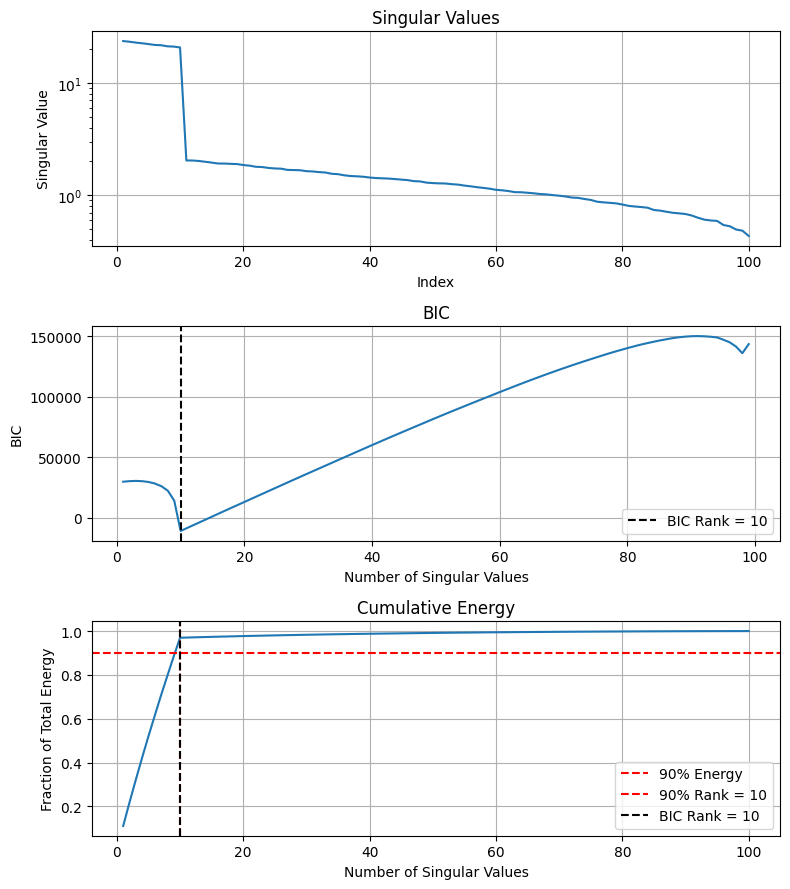

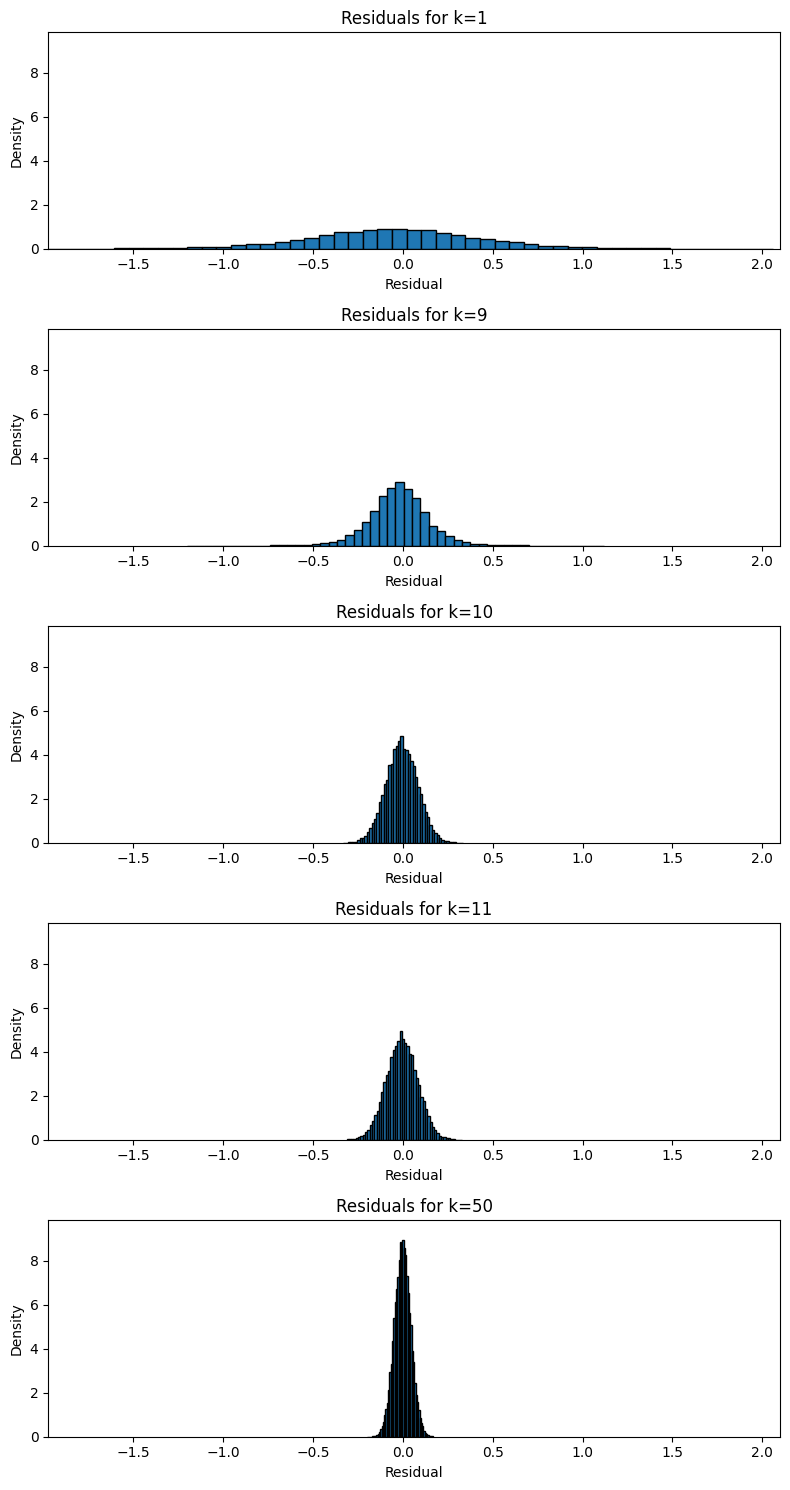

In [11]:
X10 = matrix_with_rank(10, 200, 100, scale=10)
Ux10, Sx10, Vtx10 = torch.linalg.svd(X10, full_matrices=False)
bic10 = list(gen_svd_bic3(X10, Sx10, Ux10, Vtx10))
plot_svd(Sx10.cpu().numpy(), bic10)
plot_residuals([1, 9, 10, 11, 50], X10, Sx10, Ux10, Vtx10)

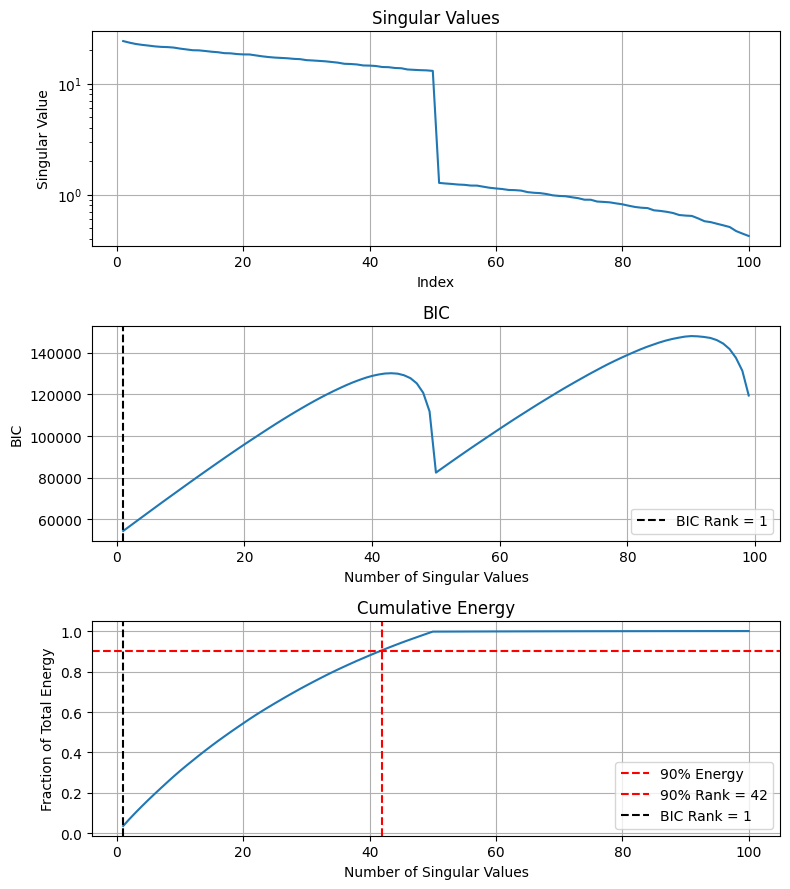

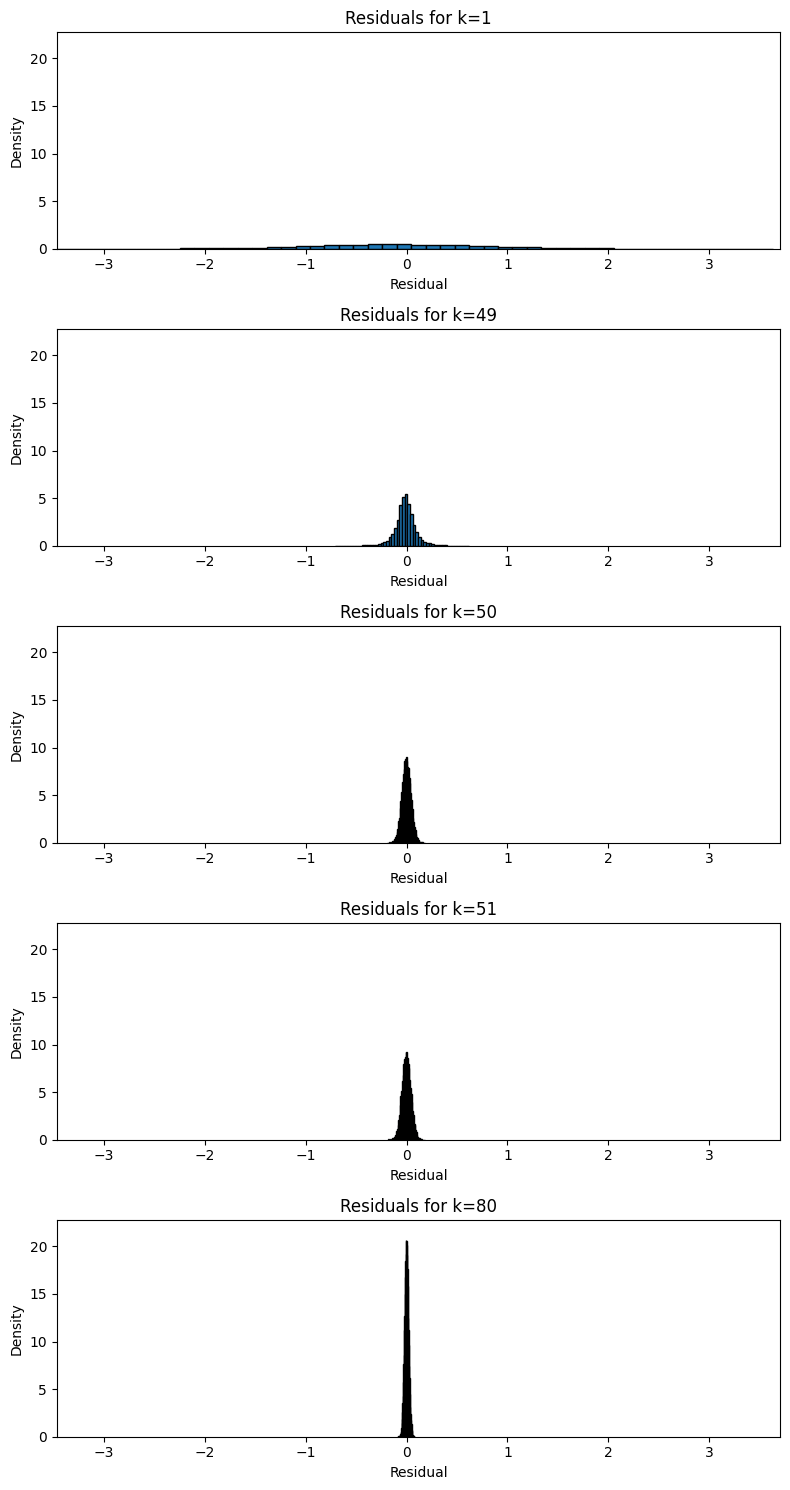

In [12]:
X = matrix_with_rank(50, 200, 100, scale=10)
Ux, Sx, Vtx = torch.linalg.svd(X, full_matrices=False)
bic = list(gen_svd_bic2(X, Sx, Ux, Vtx))
plot_svd(Sx.cpu().numpy(), bic)
plot_residuals([1, 49, 50, 51, 80], X, Sx, Ux, Vtx)
